![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 3 - Optimization Methods </center>
### <center> Stochastic Gradient Descent (SGD)</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/03_OptimizationMethods/MainSGD.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})
np.random.seed(1)

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/03_OptimizationMethods/SGD_Aux.py

In [5]:
#-- What we have so far:
from SGD_Aux import LinearLayer, ReLULayer, SequentialModel, CrossEntropyLoss, Accuracy

#### Get Fashion MNIST dataset

In [6]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTrainSet.classes
mTrainX  = oTrainSet.data.view(-1,784).numpy() / 255
mTestX   = oTestSet .data.view(-1,784).numpy() / 255
vTrainY  = oTrainSet.targets.numpy()
vTestY   = oTestSet .targets.numpy()

(
mTrainX.shape, 
vTrainY.shape, 
mTestX .shape,  
vTestY .shape
)

((60000, 784), (60000,), (10000, 784), (10000,))

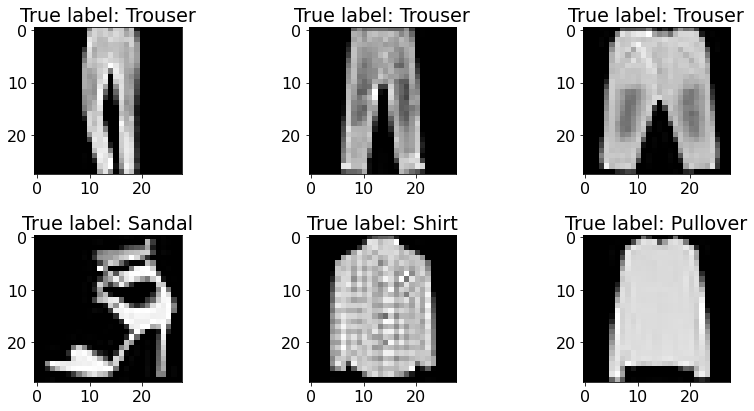

In [8]:
#-- Plot a few examples:
N, d   = mTrainX.shape
fig, _ = plt.subplots(2, 3, figsize=(12, 6))
for ax in fig.axes:
    idx = np.random.randint(N)
    ax.imshow   (np.reshape(mTrainX[idx,:], (28, 28)), cmap='gray')
    ax.set_title(f'True label: {lClasses[vTrainY[idx]]}')
    
plt.tight_layout()
plt.show()

####  Normalize data:

In [9]:
vMean = mTrainX.mean(0)
vStd  = mTrainX.std (0)

mTrainX -= vMean
mTestX  -= vMean
mTrainX /= vStd
mTestX  /= vStd

### Define a dataset (data loader) class:

In [10]:
class Dataset:
    def __init__(self, mX, vY, batchSize):
        self.mX        = mX
        self.vY        = vY
        self.N         = len(vY)
        self.batchSize = min(batchSize, self.N)
        self.nBatches  = self.N // self.batchSize
            
    def __len__(self):
        return self.nBatches
    
    #-- Loop over mini-batches:
    def __iter__(self):
        vIdx = np.random.permutation(self.N)
    
        for ii in range(self.nBatches):
            startIdx  = ii * self.batchSize
            vBatchIdx = vIdx[startIdx : startIdx + self.batchSize]
            mBatchX   = self.mX[:,vBatchIdx]
            vBatchY   = self.vY[vBatchIdx]

            yield mBatchX, vBatchY

#### A simple test for `dataset`:
Notice that we drop the last (non-full) batch

In [22]:
batchSize = 15
oDataset  = Dataset(mTrainX[:55,:].T, vTrainY[:55], batchSize)
for ii, (mXi, vYi) in enumerate(oDataset):
    print(f'mX_{ii}.shape = {mXi.shape}, vY_{ii}.shape = {vYi.shape}')
    
print(f'Dataset length = {len(oDataset)}')

mX_0.shape = (784, 15), vY_0.shape = (15,)
mX_1.shape = (784, 15), vY_1.shape = (15,)
mX_2.shape = (784, 15), vY_2.shape = (15,)
Dataset length = 3


#### Constructing train and validation data loaders:

In [23]:
batchSize = 256
oTrainSet = Dataset(mTrainX.T, vTrainY, batchSize)
oTestSet  = Dataset(mTestX.T,  vTestY,  batchSize)

### Training loop with mini-batches:

In [24]:
import time

def TrainEpoch(oModel, oTrainData, learningRate):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainData, 1):
       
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (stochasitc gradient descnet):
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]
        
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
        print(f'\rIteration: {ii:3d}: loss = {loss:2.6f}', end='')
    
    print('', end='\r')
    epochLoss /= ii
    epochAcc  /= ii
    
    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationEpoch(oModel, oValData):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oValData, 1):
        
        #-- Forward:
        mZ      = oModel.Forward(mX)
        loss, _ = CrossEntropyLoss(vY, mZ)
               
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
    
    epochLoss /= ii
    epochAcc  /= ii
    
    return epochLoss, epochAcc

### Qeustion:
Why do we use mini-batches in `ValidationLoop` as well?

#### Train model function:

In [25]:
def TrainModel(oModel, oTrainData, oValData, numEpochs, learningRate):
    for epoch in range(numEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = TrainEpoch     (oModel, oTrainData, learningRate) #-- train
        valLoss,   valAcc   = ValidationEpoch(oModel, oValData)                 #-- validation
        epochTime           = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :3d}:',  end='')
        print(' | Train loss: '     f'{trainLoss:6.3f}', end='')
        print(' | Val loss: '       f'{valLoss  :6.3f}', end='')
        print(' | Train Accuracy: ' f'{trainAcc :6.3f}', end='')
        print(' | Val Accuracy: '   f'{valAcc   :6.3f}', end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |')

### Train a shallow model (with mini-batches):

In [27]:
oModel = SequentialModel([
        LinearLayer(784, 200), ReLULayer(),
        LinearLayer(200, 10),
])

nEpochs = 10
lr      = 2e-1

TrainModel(oModel, oTrainSet, oTestSet, nEpochs, lr)

Epoch   0: | Train loss:  0.510 | Val loss:  0.454 | Train Accuracy:  0.823 | Val Accuracy:  0.844 | epoch time:  0.686 |
Epoch   1: | Train loss:  0.360 | Val loss:  0.386 | Train Accuracy:  0.871 | Val Accuracy:  0.863 | epoch time:  0.742 |
Epoch   2: | Train loss:  0.323 | Val loss:  0.390 | Train Accuracy:  0.883 | Val Accuracy:  0.865 | epoch time:  0.696 |
Epoch   3: | Train loss:  0.291 | Val loss:  0.361 | Train Accuracy:  0.894 | Val Accuracy:  0.874 | epoch time:  0.668 |
Epoch   4: | Train loss:  0.273 | Val loss:  0.373 | Train Accuracy:  0.901 | Val Accuracy:  0.869 | epoch time:  0.717 |
Epoch   5: | Train loss:  0.258 | Val loss:  0.357 | Train Accuracy:  0.906 | Val Accuracy:  0.875 | epoch time:  0.726 |
Epoch   6: | Train loss:  0.240 | Val loss:  0.357 | Train Accuracy:  0.912 | Val Accuracy:  0.876 | epoch time:  0.688 |
Epoch   7: | Train loss:  0.231 | Val loss:  0.348 | Train Accuracy:  0.915 | Val Accuracy:  0.884 | epoch time:  0.721 |
Epoch   8: | Train loss:

#### Apply model to test data:

Test accuracy: 87.94%


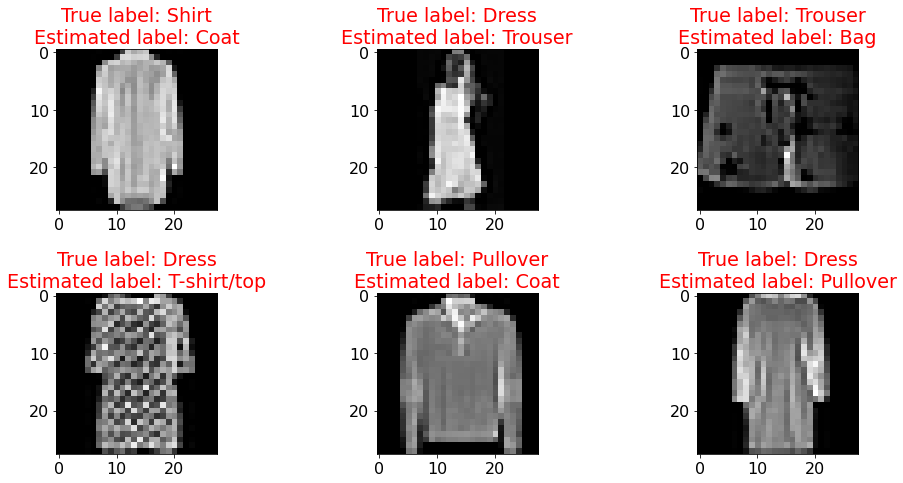

In [30]:
#-- Apply model to data:
mHatTestY = oModel.Forward(mTestX.T)
print(f'Test accuracy: {100 * Accuracy(mHatTestY, vTestY)}%')

#-- Plot a few mistakes:
vHatTestY = np.argmax(mHatTestY, axis=0)
vWrongIdx = np.nonzero(vTestY != vHatTestY)[0]

N, d   = mTestX.shape
fig, _ = plt.subplots(2, 3, figsize=(14, 7))
for ax in fig.axes:
    idx = vWrongIdx[np.random.randint(0, len(vWrongIdx))]
    ax.imshow   (np.reshape(mTestX[idx,:] * vStd + vMean, (28, 28)), cmap='gray')
    ax.set_title(f'True label: {lClasses[vTestY[idx]]}\nEstimated label: {lClasses[vHatTestY[idx]]}', color='r')
    
plt.tight_layout()
plt.show()

### Exercise
* Add a drop last flag (`bDropLast`):
    * If `bDropLast = False` then the last non-full batch is also returned in the iterations.
* Update `TrainEpoch` and `ValidationEpoch` accordingly

**Extra**: Play with the model (and the hyper-parameters) and improve your validation accuracy.

In [22]:
class Dataset:
    def __init__(self, mX, vY, batchSize, bDropLast=False):
        self.mX        = mX
        self.vY        = vY
        self.N         = len(vY)
        self.batchSize = min(batchSize, self.N)
        self.nBatches  = ???
            
    def __len__(self):
        return self.nBatches
    
    #-- Loop over mini-batches:
    def __iter__(self):
        vIdx = np.random.permutation(self.N)
    
        for ii in range(self.nBatches):
            startIdx  = ii * self.batchSize
            vBatchIdx = vIdx[startIdx : startIdx + self.batchSize]
            mBatchX   = self.mX[:,vBatchIdx]
            vBatchY   = self.vY[vBatchIdx]

            yield mBatchX, vBatchY

#### Test your implementation
You should get $4$ batches, where the last one is not full.

In [23]:
batchSize = 5
oDataset  = Dataset(mX[:17,:].T, vY[:17], batchSize)
for (mXi, vYi) in oDataset:
    print(f'mXi.shape = {mXi.shape}, vYi.shape = {vYi.shape}')

mXi.shape = (784, 5), vYi.shape = (5,)
mXi.shape = (784, 5), vYi.shape = (5,)
mXi.shape = (784, 5), vYi.shape = (5,)
mXi.shape = (784, 2), vYi.shape = (2,)


#### Update `TrainEpoch` and `ValidationEpoch`
* Remember that each mini-batch might be of a different size.
* Use `len(vY)` to get the current batch size.

In [24]:
import time

def TrainEpoch(oModel, oTrainData, learningRate):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainData):
        
        ???
        
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (stochasitc gradient descnet):
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]
        
        epochLoss += ???
        epochAcc  += ???
        print(f'\rIteration: {ii:3d}: loss = {loss:2.6f}', end='')
    
    print('', end='\r')
    epochLoss /= ???
    epochAcc  /= ???
    
    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationEpoch(oModel, oValData):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oValData):
        
        ???
        
        #-- Forward:
        mZ      = oModel.Forward(mX)
        loss, _ = CrossEntropyLoss(vY, mZ)
               
        epochLoss += ???
        epochAcc  += ???
    
    epochLoss /= ???
    epochAcc  /= ???
    
    return epochLoss, epochAcc

#### Train model function:

In [25]:
def TrainModel(oModel, oTrainData, oValData, numEpochs, learningRate):
    for epoch in range(numEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = TrainEpoch     (oModel, oTrainData, learningRate) #-- train
        valLoss,   valAcc   = ValidationEpoch(oModel, oValData)                 #-- validation
        epochTime           = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :3d}:',  end='')
        print(' | Train loss: '     f'{trainLoss:6.3f}', end='')
        print(' | Val loss: '       f'{valLoss  :6.3f}', end='')
        print(' | Train Accuracy: ' f'{trainAcc :6.3f}', end='')
        print(' | Val Accuracy: '   f'{valAcc   :6.3f}', end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |')

#### Improve your accuracy:

In [37]:
oModel = SequentialModel([???])

nEpochs = ???
lr      = ???

TrainModel(oModel, oTrainSet, oTestSet, nEpochs, lr)

SyntaxError: invalid syntax (<ipython-input-37-8e5f29408008>, line 1)